In [1]:
%matplotlib inline 

import six
import Quandl
import calendar
import numpy as np
import pandas as pd
import seaborn as sb  
import pylab as pylab
from datetime import datetime
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import interp1d
import statsmodels.stats.stattools as stats_stattools
import statsmodels.tsa.stattools as tsa_stattools
import statsmodels.tsa.seasonal as tsa_seasonal

import xgboost as xgb
from unbalanced_dataset import SMOTE

from sklearn import svm
from sklearn import metrics, cross_validation, linear_model, ensemble
from sklearn import feature_selection

import sys
from os import listdir
from os.path import isfile, join
from helpers import correlation, procces_stocks, data_manipulation, download_quandl_data, ml_dataset
from classes import Iteration, Stacking, Boosting

fig_size = [10, 6]
plt.rcParams["figure.figsize"] = fig_size
sb.set_style('darkgrid')

In [2]:
GOLD = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/GOLD.csv')
SILVER = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/SILVER.csv')
PLAT = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/PLAT.csv')
INDEX_DJIA = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_DJIA.csv')
INDEX_HSI = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_HSI.csv')
INDEX_IBEX = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_IBEX.csv')
INDEX_N225 = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_N225.csv')
INDEX_SP500 = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_SP500.csv')

values_names = ['GOLD', 'SILVER', 'PLAT', 'DJIA', 'HSI', 'IBEX', 'N225', 'SP500']
values_dfs = [GOLD, SILVER, PLAT, INDEX_DJIA, INDEX_HSI, INDEX_IBEX, INDEX_N225, INDEX_SP500]
dict_dfs_cols = {}

for index in range(len(values_names)):
    name = values_names[index]
    df = values_dfs[index]    
    cols = df.columns.values
    new_cols = [x for x in cols if x not in ['Date', 'USD_AM', 'USD_PM', 'USD', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adjusted Close']]
    
    dict_dfs_cols[name] = new_cols

dataset = ml_dataset.generate_df_dataset(values_names, values_dfs, dict_dfs_cols)

#First 30 row
dataset = dataset[31:]
dataset = dataset.reset_index(drop=True)

In [3]:
def plot_roc(fpr, tpr):
    """Plot ROC curve and display it."""
    plt.clf()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')

In [4]:
training_dates = Iteration.Iteration('1993-08-19', '2012-07-09')
testing_dates  = Iteration.Iteration('2012-07-09', '2016-04-20')
training_dates.calculate_indices(dataset)
testing_dates.calculate_indices(dataset)

trainDates = []
testDates = []
trainDates.append(training_dates.lowerIndex)
trainDates.append(training_dates.upperIndex)
testDates.append(testing_dates.lowerIndex)
testDates.append(testing_dates.upperIndex)
    
trainX, trainY, testX, testY = ml_dataset.dataset_to_train_using_dates(dataset, trainDates, testDates, binary=True)

In [5]:
N_TREES = 500
SEED = 42

selected_models = [
    "LRC:dataset",
    "LRC:dataset",
    "LRC:dataset",
    "LRC:dataset",
    "RFC:dataset",
    "RFC:dataset",
    "RFC:dataset",
    "RFC:dataset",
    "RFC:dataset",
    "GBC:dataset",
    "GBC:dataset",
    "LRC:dataset",
    "GBC:dataset",
    "GBC:dataset"
   #"RFC:effects_f",  # experimental; added after the competition
]

# Create the models on the fly
models = []
for item in selected_models:
    model_id, data_set = item.split(':')
    model = {'LRC': linear_model.LogisticRegression,
             'GBC': ensemble.GradientBoostingClassifier,
             'RFC': ensemble.RandomForestClassifier,
             'ETC': ensemble.ExtraTreesClassifier}[model_id]()
    model.set_params(random_state=SEED)
    models.append(model)

    
boosting = Boosting.Boosting(models)

###  Metrics
mean_auc = 0.0
iter_ = 1
for i in range(iter_):        
    boosting.fit_predict(trainX, trainY, testX, testY)

    #fpr, tpr, _ = metrics.roc_curve(testY, cv_preds)
    #roc_auc = metrics.auc(fpr, tpr)
    #print "AUC (fold %d/%d): %.5f" % (i + 1, iter_, roc_auc)
    #mean_auc += roc_auc
#
    #print "Mean AUC: %.5f" % (mean_auc/CONFIG.iter)


modelEN1.coef [[ 0.00779741  0.0078561   0.00785741  0.00785905  0.00315645  0.00315645
   0.00315645  0.00315645  0.00315645  0.17834328  0.17834328  0.00785695
   0.17834328  0.17834328]]
modelEN2.coef [[ 0.04829745  0.04829747  0.04829743  0.04829743  0.00781979  0.00781979
   0.00781979  0.00781979  0.00781979  0.1745775   0.1745775   0.04829743
   0.1745775   0.1745775 ]]
> AUC: 0.7347 


In [20]:
preds = rbf.predict(testX)
good = []
bad = []
for sample in range(testY.shape[0]):
    #print("X %s - Y %s" % (testY[sample], preds[sample]))
    if testY[sample] == preds[sample]:
        good.append(10)
        bad.append(0)        
    else:
        bad.append(-10)
        good.append(0)

In [23]:
#rbf = RandomForestClassifier(100)
#rbf.fit(trainX, trainY)
#print rbf.score(testX, testY)
#print classification_report(testY, rbf.predict(testX))
#print roc_auc_score(testY, rbf.predict(testX))
print len(modelEN1.coef_[0])

3


In [8]:

print type(t)
print t

<type 'list'>
<type 'tuple'>
(array([ -1.07036052e+00,  -8.92654038e-01,  -1.17760326e+00,
        -2.83742336e-01,  -6.07632373e-01,   1.34792098e+00,
         6.67589142e-01,   5.87651554e-01,   8.00087298e-01,
         3.30907720e-01,  -6.39424261e-01,  -1.16305695e+00,
        -1.59134712e+00,   4.94052432e-01,   7.18119402e-01,
         1.75019956e+00,   9.80945675e-01,  -2.18314230e-01,
         2.97889850e-01,  -3.78042806e-01,   1.44116355e+00,
         8.90614152e-01,   1.51129734e+00,   1.08129430e+00,
         1.71848842e-01,  -1.56863305e-01,   7.57708387e-01,
        -6.53243383e-01,   5.75347296e-01,   8.83356111e-01,
         9.19888904e-01,  -1.97253909e-01,  -1.04212075e+00,
        -1.97709528e-01,  -2.07326246e+00,  -2.25782748e-01,
        -2.65455645e-02,  -1.06924034e-01,  -1.08630864e+00,
        -1.22023394e+00,  -7.96145513e-01,  -8.30676974e-01,
        -2.29262336e-01,   1.01324170e+00,   1.14643083e+00,
        -6.12714768e-02,   5.94315068e-01,   1.23293215

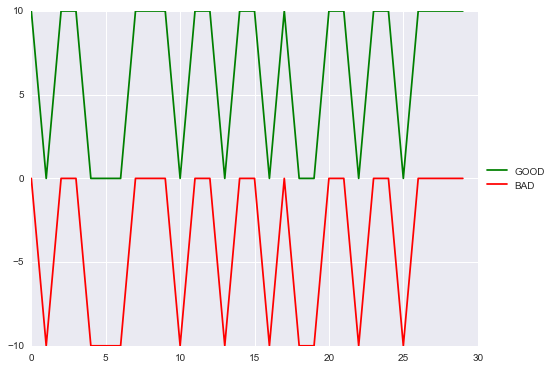

In [21]:
## PRICE FLOW BETWEEN TWO CONSECUTIVES DAYS ##
slice = 30
pylab.figure(1)

ax = plt.subplot(111)

ax.plot(good[:slice], 'g', label='GOOD')
ax.plot(bad[:slice], 'r', label='BAD')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [13]:
m2_xgb = xgb.XGBClassifier(n_estimators=110, nthread=-1, seed=1729)
m2_xgb.fit(trainX, trainY, eval_metric="auc", verbose = False, eval_set=[(testX, testY)])

# calculate the auc score
print("Roc AUC: ", roc_auc_score(testY, m2_xgb.predict_proba(testX)[:,1], average='macro'))

('Roc AUC: ', 0.49467051758396796)


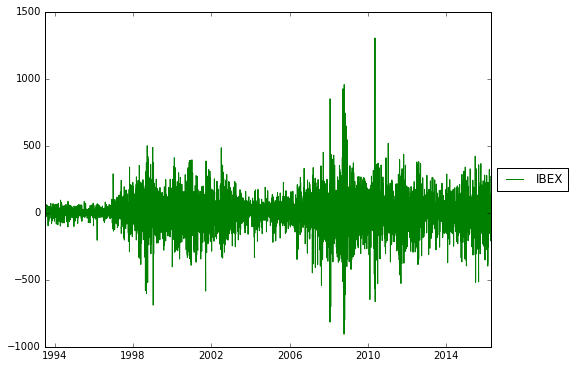

In [84]:
pylab.figure(1)

ax = plt.subplot(111)
x = [datetime.strptime(d,'%Y-%m-%d').date() for d in dataset['Date'].tolist()]
ax.plot(x, dataset['INDEX_IBEX'], 'g', label='IBEX')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [37]:
data_manipulation.write_csv_data(GOLD, '/Users/Pablo/Desktop/TFM/Data/GOLD.csv')
data_manipulation.write_csv_data(SILVER, '/Users/Pablo/Desktop/TFM/Data/SILVER.csv')
data_manipulation.write_csv_data(PLAT, '/Users/Pablo/Desktop/TFM/Data/PLAT.csv')
data_manipulation.write_csv_data(INDEX_DJIA, '/Users/Pablo/Desktop/TFM/Data/INDEX_DJIA.csv')
data_manipulation.write_csv_data(INDEX_HSI, '/Users/Pablo/Desktop/TFM/Data/INDEX_HSI.csv')
data_manipulation.write_csv_data(INDEX_IBEX, '/Users/Pablo/Desktop/TFM/Data/INDEX_IBEX.csv')
data_manipulation.write_csv_data(INDEX_N225, '/Users/Pablo/Desktop/TFM/Data/INDEX_N225.csv')
data_manipulation.write_csv_data(INDEX_SP500, '/Users/Pablo/Desktop/TFM/Data/INDEX_SP500.csv')